In [20]:
import model1
from data import DataCollector
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import torch.nn as nn
import torch
height = 512
width = 384
classes = {"cardboard":(0, 403),
        "glass":(1, 501),
        "metal":(2, 410),
        "paper":(3, 594),
        "plastic":(4, 482)}

classes_original = {"cardboard":(0, 34),
        "glass":(1, 20),
        "metal":(2, 26),
        "paper":(3, 42),
        "plastic":(4, 33)}

        # "trash":(5, 137)}
# numlimit = 200
# classes = {"cardboard":(0, numlimit),
#         "glass":(1, numlimit),
#         "metal":(2, numlimit),
#         "paper":(3, numlimit),
#         "plastic":(4, numlimit),
#         "trash":(5, min(137,numlimit))}

skin_tones = {0:(41, 23, 9),#darker
              1:(95, 51, 16),
              2:(127, 68, 34),
              3:(178, 102, 68),
              4:(115, 63, 23),
              5:(147, 95, 55),
              6:(173, 138, 96),
              7:(207, 150, 95),
              8:(187, 101, 54),
              9:(212, 158, 122),
              11:(242, 194, 128),
              12:(236, 192, 145),
              13:(249, 212, 160),
              14:(248, 217, 152),
              15:(253, 231, 173),
              16:(254, 227, 197)}#paler
collector3 = DataCollector(height, width, classes_original)
datasets3 = collector3.collect('original_trashnet/original_dataset',resnet_label = 34, val_size=0.25, test_size=0.5,class_balanced=False)

Store in X and y


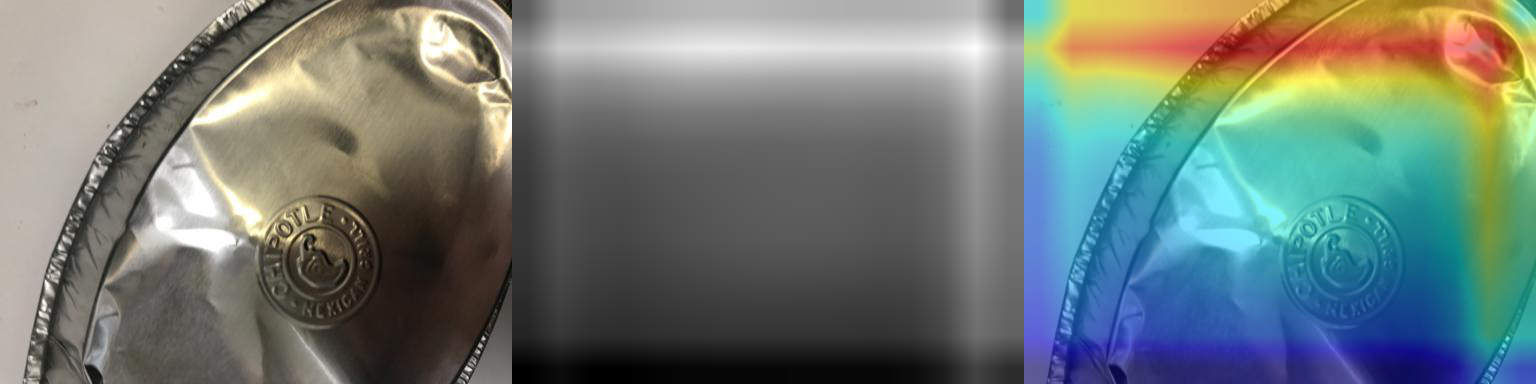

In [40]:
import warnings
warnings.filterwarnings('ignore')
from torchvision.models import resnet34,ResNet34_Weights
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from gradcam.utils import find_resnet_layer
model = resnet34()
# model.load_state_dict(torch.load("ResNet34_Weights.pth"))
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)
# model.load_state_dict(torch.load('models/seqno6_model4/model.pth'))
model.load_state_dict(torch.load('models/seqno6_model1_train_final_layer/model.pth'))

model.eval()
class_label = 2
img_idx = 11
img = np.array(Image.open(f'trashnet/dataset-resized/{list(classes.keys())[class_label]}/{list(classes.keys())[class_label]}{img_idx}.jpg'))

# img = np.array(Image.open(f'original_trashnet/original_dataset/{list(classes.keys())[class_label]}/{list(classes.keys())[class_label]}{img_idx}.jpg'))
# img = cv2.resize(img, (512, 384))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=ResNet34_Weights.DEFAULT.transforms().mean,std = ResNet34_Weights.DEFAULT.transforms().std)
# target_layers  = [find_resnet_layer(model, 'fc')]
target_layers=[model.layer4[-1]]
cam =  GradCAM(model=model, target_layers=target_layers)
grayscale_cams = cam(input_tensor=input_tensor)#, targets=targets
cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [41]:
model.cuda()
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [35]:
class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

In [69]:
features_fn = nn.Sequential(*list(model.children())[:-2])
classifier_fn = nn.Sequential(*(list(model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]))
sal = GradCAM(input_tensor, int(2), features_fn, classifier_fn)

In [70]:
sal = Image.fromarray(sal)
sal = sal.resize(img.shape[:2], resample=Image.LINEAR)

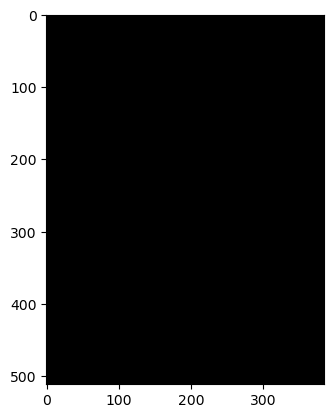

In [71]:
plt.imshow(sal)